In [34]:
import sys
import numpy as np
import torch 
# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from importlib import reload
import pandas as pd 
import seaborn as sns

# import nn PCA model from nuclear-norm-pca
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca')
import kuckle_model
from kuckle_model import *

### Settings and Load data

In [5]:
leaflet_repo = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/' #need to move load_cluster_data function to general module utils 
sys.path.append(leaflet_repo)
import load_cluster_data
from betabinomo_mix_singlecells import *

In [3]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

cpu


In [6]:
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'
cell_types = ['Brain_Non-Myeloid_brain_pericyte',
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell',
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte',
 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage',
 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']#ignoring Bergmann_glial_cell since very few cells

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=5000, celltypes=cell_types, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")

# get indices (maybe don't need this actually)
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/


Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Non-Myeloid_brain_pericyte', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_endothelial_cellBrain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
5527
13952
The maximum junction count was initially:  36797
33
The maximum junction count is now:  4982
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
1  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
2  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...       10              16   
3  A1

### Filter junctions and set up Y and W (weight matrix of inverse variances of the PSI values)

also printing original indices of junctions we are keeping


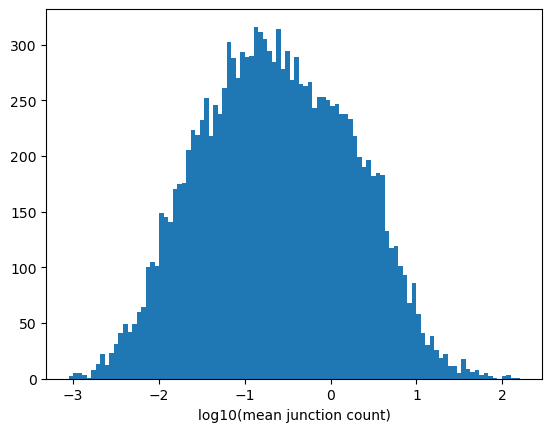

In [9]:
junc_counts_sub, cluster_counts_sub, junc_keep = filter_junctions(
    junc_counts, cluster_counts, plot = True)

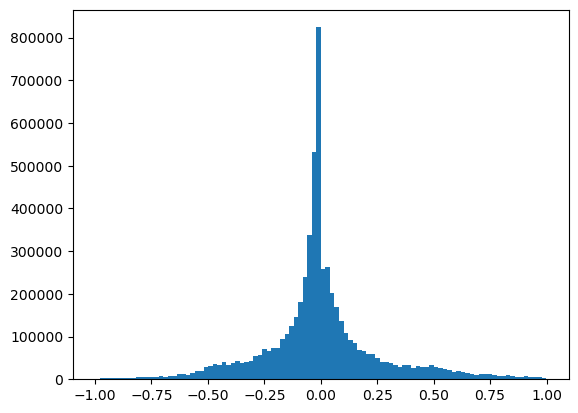

In [10]:
# set up data for nuc norm PCA
Y_data, w = make_Y(
    junc_counts_sub, cluster_counts_sub, float_type)

# np.mean(Y_data * Y_data) * psi.shape[0] * psi.shape[1]
Y = torch.tensor(Y_data, **float_type)
W = torch.tensor(w.data, **float_type)

_ = plt.hist(Y_data, 100) # centered so the distribution peaks at 0 and is in [-1,1]

### Split into training and test data 

In [13]:
Y_train, W_train, indices_train, Y_test, W_test, indices_test = train_test(
    Y_data, w, float_type)

### Run nuclear norm PCA constraint search 

In [14]:
rmseTol = 5e-5
its=10

rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = constraint_search(
    indices_train, 
    Y_train, 
    W_train, 
    size = junc_counts_sub.shape,
    indices_test = indices_test, 
    Y_test = Y_test, 
    W_test = W_test, 
    rmseTol = rmseTol, 
    end = "\n",
    inner_verbose = True,
    power_iteration_controller = (30,1.),
    its = its,  
    **float_type)

CV	Bound	RMSE	TestRMSE
It	RMSE	Step	DeltaRMSE
CV	1e+03	0.224	0.228053028
It	RMSE	Step	DeltaRMSE


/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca/kuckle_model.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi, dtype = float_type["dtype"], device = "cpu") # this is always on CPU


CV	1.5e+03	0.219	0.2274296
It	RMSE	Step	DeltaRMSE
CV	2.25e+03	0.214	0.225531
It	RMSE	Step	DeltaRMSE
CV	3.38e+03	0.21	0.2243978
It	RMSE	Step	DeltaRMSE
CV	5.06e+03	0.205	0.2236874
It	RMSE	Step	DeltaRMSE
CV	7.59e+03	0.202	0.2233438
It	RMSE	Step	DeltaRMSE
CV	1.14e+04	0.198	0.2233362
It	RMSE	Step	DeltaRMSE
CV	1.71e+04	0.194	0.2223546
It	RMSE	Step	DeltaRMSE
CV	2.56e+04	0.191	0.2226943
It	RMSE	Step	DeltaRMSE
CV	3.84e+04	0.187	0.22203376
It	RMSE	Step	DeltaRMSE
CV	5.77e+04	0.184	0.22228087
It	RMSE	Step	DeltaRMSE


### Plot results 

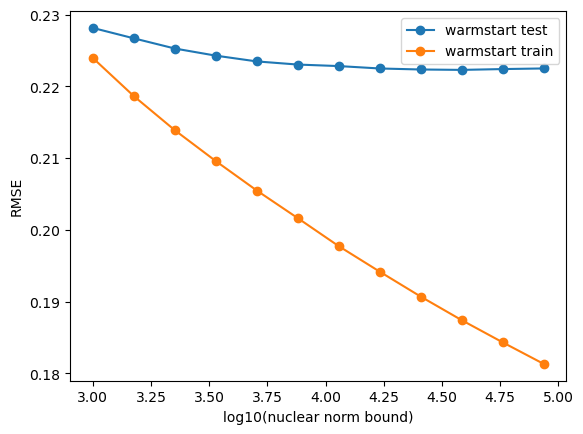

In [15]:
plt.plot(np.log10(rs), testErrors,"-o", label = "warmstart test") #rs = list of nuclear norm bounds used 
plt.plot(np.log10(rs), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(nuclear norm bound)")
plt.legend()

tensor(3759.5903)

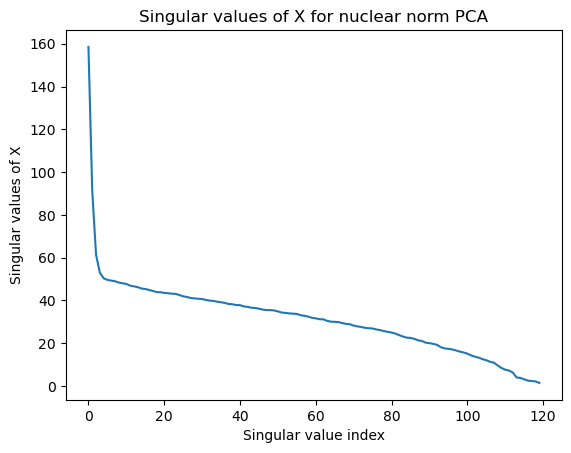

In [21]:
plt.plot(final_svd.S)
plt.ylabel("Singular values of X") 
plt.xlabel("Singular value index")
# add title
plt.title("Singular values of X for nuclear norm PCA")
final_svd.S.sum()

In [26]:
nuc_norms # nuc_norms.append(final_svd.S.sum().item())

[418.2429504394531,
 719.1759643554688,
 1014.447509765625,
 1311.49560546875,
 1617.40283203125,
 1926.65576171875,
 2261.658203125,
 2567.189697265625,
 2877.450927734375,
 3178.8486328125,
 3469.25,
 3759.59033203125]

Text(0, 0.5, 'log10(Nuc norm obtained)')

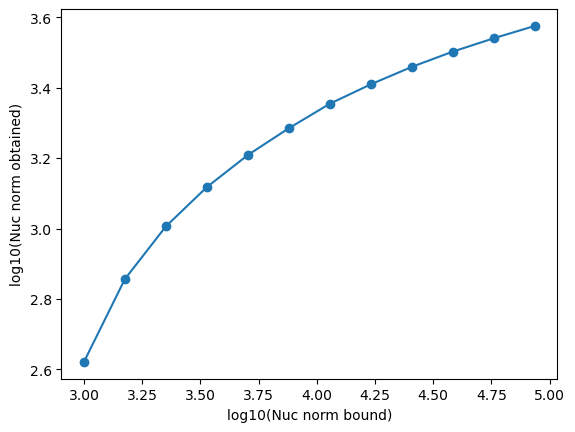

In [22]:
# solution is on the boundary up to about ~1e4, then is inside. 
plt.plot(np.log10(rs), np.log10(nuc_norms), "-o", label = "warmstart")
plt.xlabel("log10(Nuc norm bound)")
plt.ylabel("log10(Nuc norm obtained)")

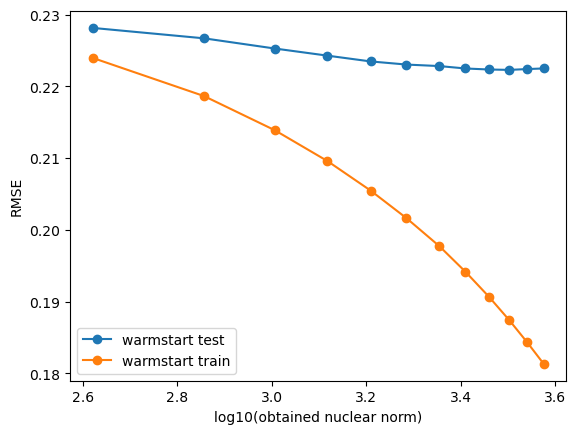

In [23]:
plt.plot(np.log10(nuc_norms), testErrors,"-o", label = "warmstart test")
plt.plot(np.log10(nuc_norms), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(obtained nuclear norm)")
plt.legend()

In [27]:
r_best = rs[np.argmin(testErrors)]
r_best

38443.359375

In [28]:
Y,W,indices = to_torch(Y_data, w, **float_type)

### Re-run constraint_search with our best r_best

In [33]:
rs, _, trainErrors_all, nuc_norms_all, final_svd_all, step_times = constraint_search(
    indices, 
    Y, 
    W, 
    size = junc_counts_sub.shape,
    rmseTol = rmseTol, 
    its = its,  
    max_r = r_best, 
    end = "\n",
    **float_type)


CV	Bound	RMSE	TestRMSE


/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca/kuckle_model.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi, dtype = float_type["dtype"], device = "cpu") # this is always on CPU


CV	1e+03	0.224	nan
CV	1.5e+03	0.22	nan
CV	2.25e+03	0.215	nan
CV	3.38e+03	0.212	nan
CV	5.06e+03	0.208	nan
CV	7.59e+03	0.205	nan
CV	1.14e+04	0.201	nan
CV	1.71e+04	0.198	nan
CV	2.56e+04	0.195	nan
CV	3.84e+04	0.192	nan


In [46]:
r_best

38443.359375

### Settings and Load data

Text(0.5, 1.0, 'Singular values of X for nuclear norm PCA')

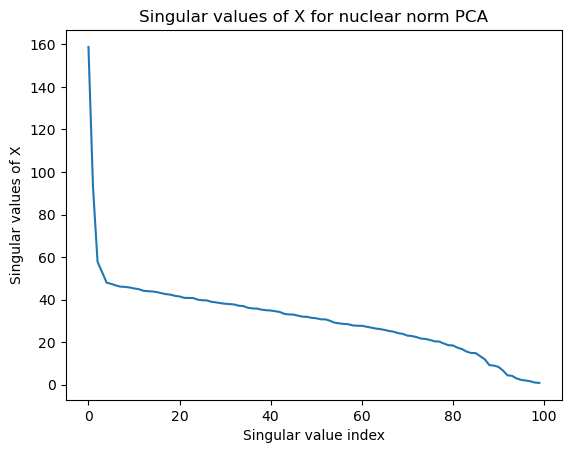

In [36]:
plt.plot(final_svd_all.S) # final_svd = orthonormer(U, V, phi) --> orthonormalization process on the singular vectors (stored in U and V) and singular values (phi) obtained from the nuc_norm_PCA
 # add xlab 
plt.xlabel("Singular value index")
# add ylab
plt.ylabel("Singular values of X")
# add title
plt.title("Singular values of X for nuclear norm PCA")

In [41]:
final_svd_all.U

tensor([[ 0.0079, -0.0077,  0.0462,  ..., -0.0068, -0.0043,  0.0013],
        [-0.0034, -0.0148,  0.0462,  ..., -0.0013, -0.0044,  0.0015],
        [ 0.0023, -0.0023,  0.0180,  ..., -0.0028, -0.0006,  0.0117],
        ...,
        [-0.0085, -0.0157, -0.0028,  ...,  0.0110,  0.0038, -0.0031],
        [-0.0126, -0.0196, -0.0009,  ..., -0.0230, -0.0002,  0.0053],
        [-0.0089, -0.0123,  0.0005,  ...,  0.0125,  0.0031,  0.0071]])

In [40]:
# convert to df and rename columns to be PCA_1, PCA_2, etc.
PC_df = pd.DataFrame(final_svd_all.U)
PC_df.columns = ["PCA_" + str(i) for i in range(1, PC_df.shape[1] + 1)]
PC_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()
PC_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100,cell_type
0,0.007916,-0.007739,0.046169,-0.011814,-0.004900,0.016922,-0.016018,0.004192,-0.003116,0.001053,...,0.001075,0.012363,0.003456,0.007298,-0.000387,-0.000894,-0.006806,-0.004279,0.001265,Brain_Non-Myeloid_brain_pericyte
1,-0.003443,-0.014799,0.046236,0.022902,-0.008759,0.001999,-0.011289,0.021236,-0.024311,-0.031082,...,-0.008740,0.020726,0.017778,-0.016253,0.025889,0.012274,-0.001292,-0.004425,0.001513,Brain_Non-Myeloid_brain_pericyte
2,0.002287,-0.002309,0.018001,0.005525,0.001190,0.011339,0.001975,0.004361,0.005486,0.004932,...,0.002628,0.005474,-0.006981,0.004732,0.003559,-0.003859,-0.002755,-0.000646,0.011679,Brain_Non-Myeloid_brain_pericyte
3,-0.000117,-0.023438,0.058598,-0.000613,0.011237,-0.004747,0.006368,0.005523,0.002086,-0.000373,...,-0.005717,0.008317,-0.003451,0.006468,-0.003853,-0.013737,-0.014434,-0.002695,0.020873,Brain_Non-Myeloid_brain_pericyte
4,-0.004706,-0.030152,0.076478,-0.023899,-0.013222,0.014575,0.010974,-0.042676,-0.031981,0.023722,...,0.007496,0.075892,0.017338,0.020555,0.100859,0.026914,-0.005337,0.028299,-0.038872,Brain_Non-Myeloid_brain_pericyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5522,-0.003662,-0.007587,-0.000340,-0.009423,-0.010159,0.007008,0.001489,0.009287,-0.005239,-0.007769,...,-0.005887,0.003664,0.015721,0.012077,0.008504,-0.004029,0.009402,0.006368,0.005916,Brain_Non-Myeloid_astrocyte
5523,-0.004208,-0.007639,-0.001299,-0.012332,-0.000709,-0.004401,-0.000340,-0.004340,0.000874,0.000366,...,0.001509,-0.000944,-0.004411,0.000428,0.001347,-0.007351,0.008014,0.001993,0.002709,Brain_Non-Myeloid_astrocyte
5524,-0.008523,-0.015742,-0.002801,-0.010318,0.002432,-0.016100,0.001489,0.005148,0.004875,-0.005096,...,-0.015294,-0.012932,0.000210,0.011307,-0.000339,-0.005249,0.011042,0.003812,-0.003115,Brain_Non-Myeloid_astrocyte
5525,-0.012584,-0.019602,-0.000893,-0.024776,0.007535,-0.003717,0.004010,0.001695,0.009254,0.006346,...,0.006931,0.011494,0.044748,0.003787,0.007587,-0.014165,-0.023005,-0.000247,0.005268,Brain_Non-Myeloid_astrocyte


<Axes: xlabel='PCA_1', ylabel='PCA_2'>

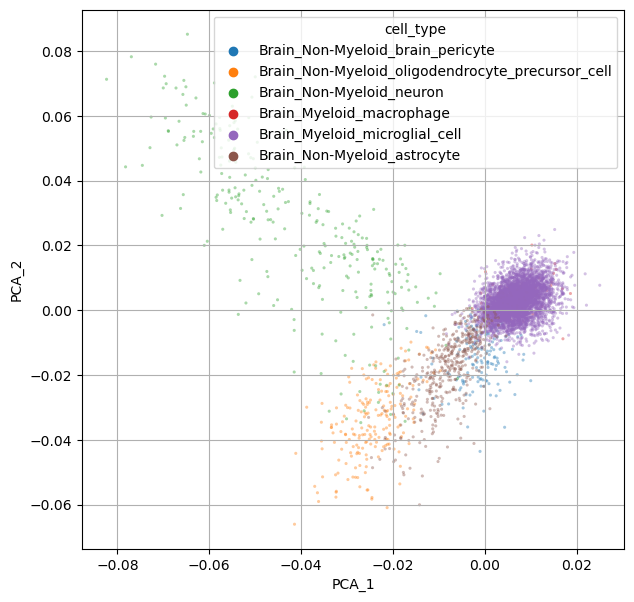

In [44]:
plt.figure(figsize=[7,7])
# add grid to plot
plt.grid()
sns.scatterplot(x = "PCA_1",y = "PCA_2", hue="cell_type", data= PC_df, edgecolor = 'none', alpha = 0.4, s=5)

<Axes: xlabel='PCA_1', ylabel='PCA_3'>

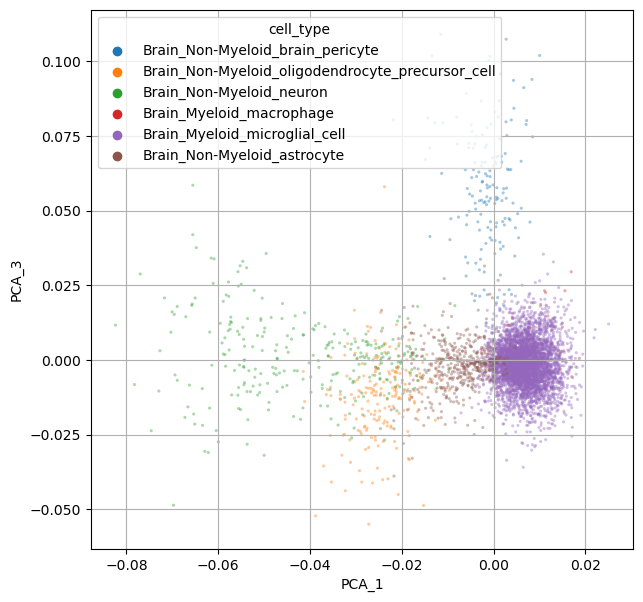

In [45]:
plt.figure(figsize=[7,7])
# add grid to plot
plt.grid()
sns.scatterplot(x = "PCA_1",y = "PCA_3", hue="cell_type", data= PC_df, edgecolor = 'none', alpha = 0.4, s=5)

Text(0.5, 0, 'Singular value index')

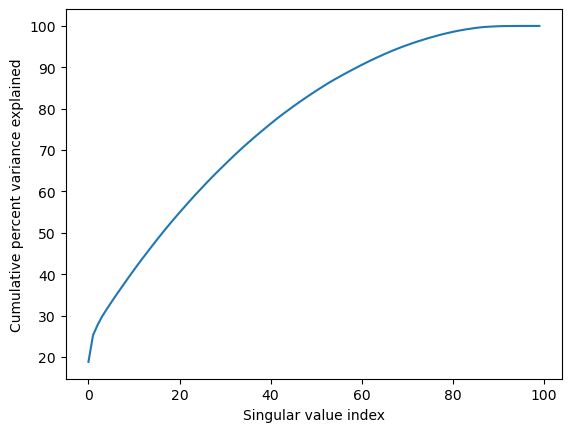

In [49]:
pve = final_svd_all.S**2
pve /= pve.sum()
pve = pve.cumsum(0) * 100
plt.plot(pve)
plt.ylabel("Cumulative percent variance explained")
# add xlabel
plt.xlabel("Singular value index")

In [64]:
final_svd_all.U

tensor([[ 0.0079, -0.0077,  0.0462,  ..., -0.0068, -0.0043,  0.0013],
        [-0.0034, -0.0148,  0.0462,  ..., -0.0013, -0.0044,  0.0015],
        [ 0.0023, -0.0023,  0.0180,  ..., -0.0028, -0.0006,  0.0117],
        ...,
        [-0.0085, -0.0157, -0.0028,  ...,  0.0110,  0.0038, -0.0031],
        [-0.0126, -0.0196, -0.0009,  ..., -0.0230, -0.0002,  0.0053],
        [-0.0089, -0.0123,  0.0005,  ...,  0.0125,  0.0031,  0.0071]])

In [68]:
final_svd_all.V.shape

torch.Size([100, 13598])

In [63]:
final_svd_all.S

tensor([158.8425,  92.9214,  57.7590,  52.8602,  47.9405,  47.3858,  46.6670,
         46.0801,  45.9710,  45.6846,  45.2463,  44.9159,  44.1596,  43.9515,
         43.8142,  43.5219,  43.0046,  42.5469,  42.3149,  41.7519,  41.4589,
         40.8091,  40.7585,  40.7120,  39.9563,  39.6728,  39.5913,  38.9465,
         38.6628,  38.3068,  38.0367,  37.8702,  37.6903,  37.1141,  36.9245,
         36.1493,  35.8255,  35.7460,  35.2441,  34.9955,  34.8543,  34.5135,
         34.1646,  33.2902,  33.0046,  32.9345,  32.4350,  31.9486,  31.8818,
         31.3937,  31.2010,  30.7152,  30.6878,  30.0547,  29.1291,  28.8379,
         28.5283,  28.4290,  27.8497,  27.6983,  27.6701,  27.2432,  26.8402,
         26.3856,  26.1232,  25.7208,  25.2252,  24.8880,  24.1994,  23.8797,
         23.0550,  22.8415,  22.3629,  21.6543,  21.4760,  20.9613,  20.3663,
         20.2324,  19.3525,  18.5337,  18.4262,  17.4000,  16.7259,  15.5505,
         14.8644,  14.8255,  13.3769,  11.9538,   9.2029,   8.93

In [67]:
E = final_svd_all.U * final_svd_all.S  #in U, these are like the PCs..., S are the scaling factors that quantify the amount of variance captured by each corresponding singular vector in U.
E

tensor([[ 1.2574e+00, -7.1913e-01,  2.6667e+00,  ..., -1.0737e-02,
         -4.0638e-03,  9.9513e-04],
        [-5.4684e-01, -1.3751e+00,  2.6705e+00,  ..., -2.0386e-03,
         -4.2025e-03,  1.1900e-03],
        [ 3.6321e-01, -2.1459e-01,  1.0397e+00,  ..., -4.3458e-03,
         -6.1336e-04,  9.1836e-03],
        ...,
        [-1.3538e+00, -1.4627e+00, -1.6179e-01,  ...,  1.7420e-02,
          3.6207e-03, -2.4498e-03],
        [-1.9989e+00, -1.8215e+00, -5.1586e-02,  ..., -3.6292e-02,
         -2.3448e-04,  4.1422e-03],
        [-1.4094e+00, -1.1426e+00,  2.6125e-02,  ...,  1.9658e-02,
          2.9193e-03,  5.5923e-03]])

In [51]:
color_palette = sns.color_palette("Set1", n_colors=len(cell_ids_conversion['cell_type'].unique()))
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_ids_conversion['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_ids_conversion.cell_type.values

# create colours for each cell type 
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00, 5.00000e+00,
        2.00000e+00, 3.00000e+00, 6.00000e+00, 3.00000e+00, 3.00000e+00,
        5.00000e+00, 4.00000e+00, 4.00000e+00, 1.10000e+01, 4.00000e+00,
        1.30000e+01, 1.40000e+01, 5.00000e+00, 8.00000e+00, 7.00000e+00,
        5.00000e+00, 8.00000e+00, 5.00000e+00, 4.00000e+00, 6.00000e+00,
        7.00000e+00, 4.00000e+00, 8.00000e+00, 7.00000e+00, 1.00000e+01,
        1.70000e+01, 9.00000e+00, 2.30000e+01, 1.50000e+01, 2.70000e+01,
        3.00000e+01, 4.30000e+01, 4.90000e+01, 5.60000e+01, 6.70000e+01,
        6.10000e+01, 8.30000e+01, 8.30000e+01, 1.25000e+02, 1.28000e+02,
        1.43000e+02, 1.98000e+02, 3.17000e+02, 5.18000e+02, 8.58000e+02,
        1.55100e+03, 3.05000e+03, 6.17400e+03, 1.28510e+04, 2.66490e+04,
        5.36080e+04, 1.01743e+05, 1.75081e+05, 8.21820e+04, 4.23050e+04,
        2.13350e+04, 1.04980e+04, 5.35700e+03, 2.85

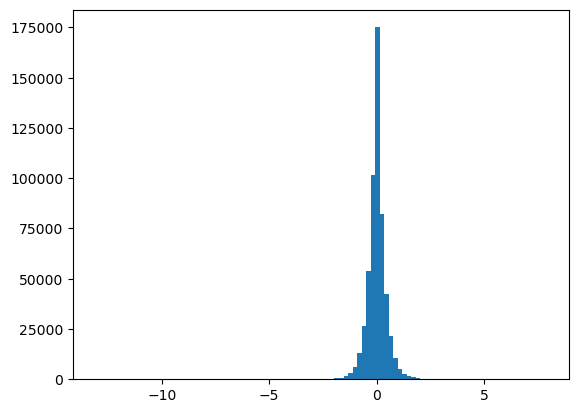

In [60]:
# make a histogram of all the values in the torch tensor E
plt.hist(E.flatten(), 100)

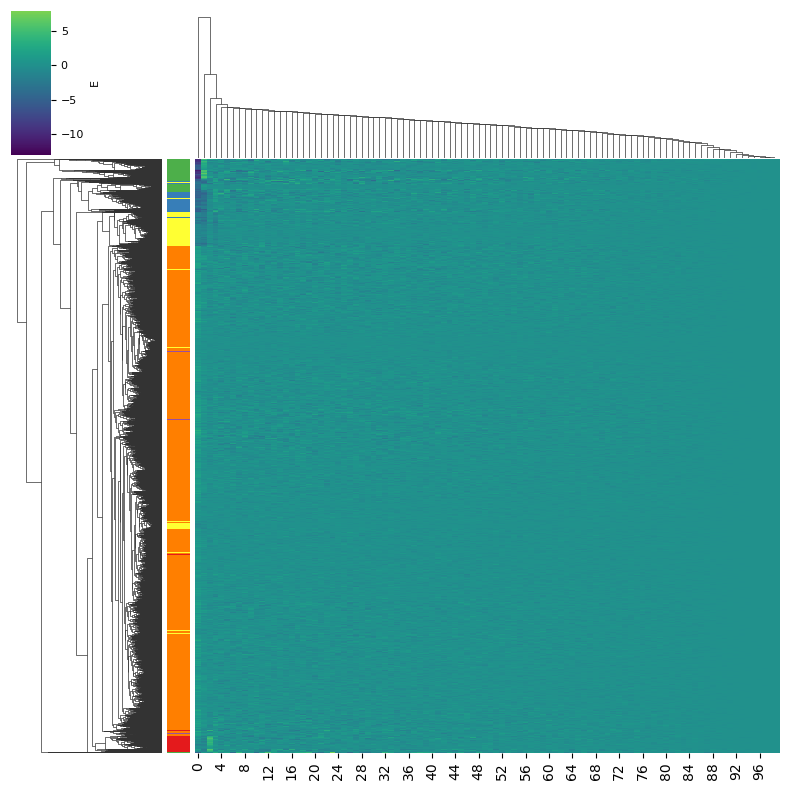

In [62]:
cluster = sns.clustermap(
    data=E,
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    yticklabels=False,
    figsize=(8, 8),
    center=0,
    row_colors=row_colors,  # Apply row colors
    cbar_kws={'label': 'E'} 
    )
cluster.cax.set_ylabel('E', size=8)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(8)

Text(0.5, 0, 'Cell Type')

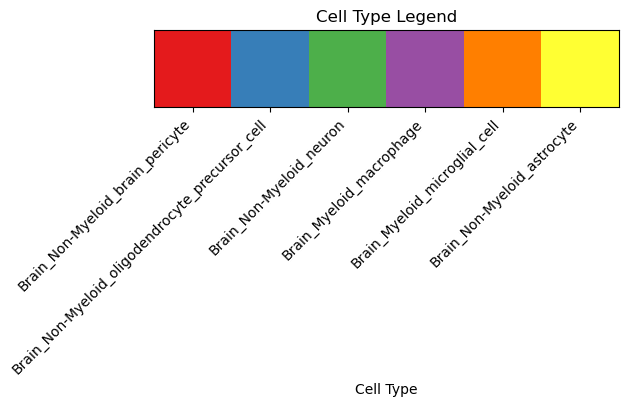

In [54]:
# print cell type color legend seperately
cell_type_colors
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)
sns.palplot(color_palette)
plt.title("Cell Type Legend")
# add cell type names to legend
plt.xticks(np.arange(len(unique_cell_types)), unique_cell_types, rotation=45, ha='right')
plt.xlabel("Cell Type")

In [55]:
# let's calculate silhouette score ussing assign_post
silhouette_score(E, cell_types)

0.054299932